# MNIST database classification
This example is based on the work of quantum neural networks used as classifiers by Farhi et al (https://arxiv.org/abs/1802.06002).

A quantum and a classical neural network are compared on how they can classify pictures that represent two possible handwritten digits (a 3 and a 6).

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


## Load the data
We upload the MNIST database from Keras

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Now we can filter the pictures that only represent a 3 or a 6 and relabel them for binary classification, such that 3 corresponds to `True` ans 6 to `False`.

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [6]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


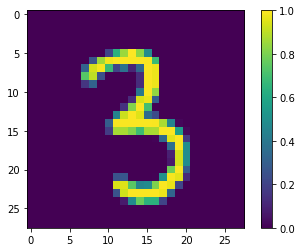

In [19]:
print(y_train[0])

plt.imshow(x_train[29, :, :, 0])
plt.colorbar()


### 1.1 Downscale the image
The images in MNIST are 28x28, which means that they're too big for a quantum device. We rescale them to 4x4

In [8]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()


True


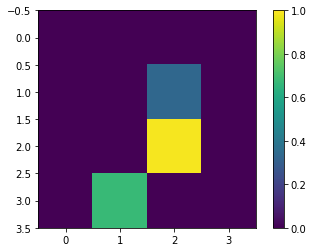

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


### 1.2 Removing contradictory examples
Because of the pixellation due to going from 28x28 to 4x4, some of the samples corresponding to the same unique picture are labelled sometimes as a 3 and sometimes as a 6. This is contradictory for classifiers and it is handled by the next function.

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [13]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)


Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.3 Encode the data as quantum circuits
Here we convert the remaining pictures to binary encoding. This uses a threshold, which intuitively means that the pixel is zero or one depending on its intensity being higher or lower than the threshold.

In [14]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

# print(x_train_bin)

In [15]:
_ = remove_contradicting(x_train_bin, y_train_nocon)


Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


Now we can encode each of the strings (corresponding to images) with a circuit that applies a $X$ gate depending on whethere the bit intensity is higher than a given threshold.

Note: the encoding circuit must have as many qubits as there are pixels.

In [16]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]


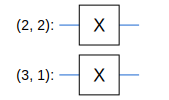

In [21]:
SVGCircuit(x_train_circ[0])


How do we know that the previous circuit properly encodes the bitstring? Well, we can show the indices of the bistring-image which are non-zero.

In [22]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Finally, the quantum circuits can be converted to tensors for `tfq`.

In [23]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)


## Quantum neural network
### Build the circuit
This uses the idea of building a parametrized circuit of $e^{iXX}$ and $e^{iZZ}$ layers. In each layer the data qubits act on the readout qubit, of which, eventually, we want to know the expectation value.


In [24]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            # the readout is always the target
            circuit.append(gate(qubit, self.readout)**symbol)


Now we can build an example circuit

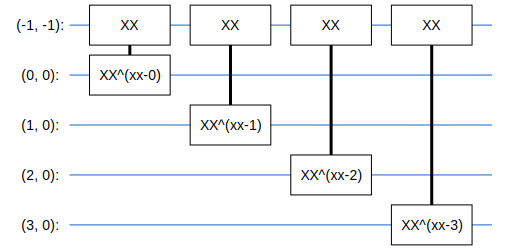

In [25]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


We can now make a function for our parametrized circuit. In doing this we need to decide on a number of layers (e.g. 2).

In [26]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [29]:
model_circuit, model_readout = create_quantum_model()
# SVGCircuit(model_circuit)

### Wrap the model-circuit in a tfq-keras model

The circuit model we created can be wrapped into a tfw-keras one, which will allow to define a cost and an accuracy and to train the parameters.

In [30]:
# Build the keras model
model = tf.keras.Sequential([
    # The input layer is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1, 1].
    tfq.layers.PQC(model_circuit, model_readout)
])

Since we want to minimize the expectation value of the readout (range = \[-1, 1\]), we can use the *hinge loss* as a cost function. For this we must convert the labels of the images we still have

In [31]:
y_train_hinge = 2. * y_train_nocon - 1.
y_test_hinge = 2. * y_test - 1.

Now for the accuracy metric. We want to use the `hinge_accuracy` as defined below

In [32]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.
    y_pred = tf.squeeze(y_pred) > 0.
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

The following line creates the quantum machine learning model (loss + optimizer + metrics).

In [33]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy]
)

In [35]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


Now the model can be trained. For the sake of brevity, we reduce the number of training examples (32 parameters can be trained well enough with 500 samples) and define the number of epochs and the batch size.

In [36]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = 500

In [37]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [38]:
qnn_history = model.fit(
    x_train_tfcirc_sub, y_train_hinge_sub,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test)
)

qnn_results = model.evaluate(x_test_tfcirc, y_test)

2021-07-12 15:46:28.953821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-12 15:46:28.978068: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
Epoch 1/3
157/157 [==============================] - 88s 555ms/step - loss: 0.9808 - hinge_accuracy: 0.5614 - val_loss: 0.7020 - val_hinge_accuracy: 0.7979
Epoch 2/3
157/157 [==============================] - 87s 554ms/step - loss: 0.5951 - hinge_accuracy: 0.8125 - val_loss: 0.4304 - val_hinge_accuracy: 0.8029
Epoch 3/3
62/62 [==============================] - 4s 69ms/step - loss: 0.3615 - hinge_accuracy: 0.8992


## Classical Neural Network

In the following, we will see how a classical neural network can outperform a quantum one for classical data classification. In the first case, we won't reduce the dimensionality of the data and keep the images as 28 x 28. In the second case, we will use the 4 x 4 reduced images with just 37 parameter, which is a model more similar to the quantum one.

In [43]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [44]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.9985


Now for the 'fair' model

In [45]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 0s - loss: 0.6750 - accuracy: 0.5584 - val_loss: 0.6577 - val_accuracy: 0.5152
Epoch 2/20
81/81 - 0s - loss: 0.6278 - accuracy: 0.6163 - val_loss: 0.6108 - val_accuracy: 0.6509
Epoch 3/20
81/81 - 0s - loss: 0.5823 - accuracy: 0.7453 - val_loss: 0.5623 - val_accuracy: 0.7932
Epoch 4/20
81/81 - 0s - loss: 0.5397 - accuracy: 0.8167 - val_loss: 0.5210 - val_accuracy: 0.8028
Epoch 5/20
81/81 - 0s - loss: 0.5032 - accuracy: 0.8358 - val_loss: 0.4859 - val_accuracy: 0.8186
Epoch 6/20
81/81 - 0s - loss: 0.4714 - accuracy: 0.8522 - val_loss: 0.4556 - val_accuracy: 0.8323
Epoch 7/20
81/81 - 0s - loss: 0.4441 - accuracy: 0.8565 - val_loss: 0.4298 - val_accuracy: 0.8328
Epoch 8/20
81/81 - 0s - loss: 0.4205 - accuracy: 0.8573 - val_loss: 0.4076 - val_accuracy: 0.8328
Epoch 9/20
81/81 - 0s - loss: 0.4001 - accuracy: 0.8572 - val_loss: 0.3883 - val_accuracy: 0.8323
Epoch 10/20
81/81 - 0s - loss: 0.3823 - accuracy: 0.8576 - val_loss: 0.3714 - val_accuracy: 0.8323
Epoch 11/20
81/81 -

## Comparison

/home/giorgio/.pyenv/versions/3.8.2/envs/aqa_course/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

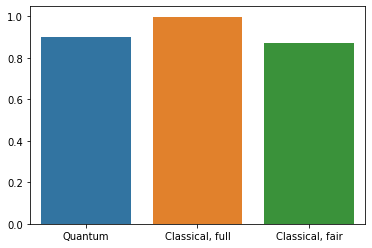

In [47]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])